In [12]:
import torch
import importlib
import homework4
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


importlib.reload(homework4)

CNP = homework4.CNP

In [ ]:
def log_prob_loss(output, target):
    #print(f"Output : {output} target: {target}")
    mean, sigma = output
    #print(f"Output: {output}, Target: {target}, Mean: {mean}, Sigma: {sigma}")
    dist = torch.distributions.Independent(torch.distributions.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

def generate_samples(traj: torch.Tensor):  
    rnd_indexes = torch.randint(0, len(traj), (4,))
    random_rows = traj[rnd_indexes] 
    rnd_indexes = rnd_indexes.float() / (len(traj) - 1)
    random_rows = torch.cat((rnd_indexes.unsqueeze(-1).float(), random_rows), dim=1)
    tensor_1 = random_rows[:3].unsqueeze(0)
    tensor_2 = random_rows[3][:2].unsqueeze(0).unsqueeze(0)
    tensor_3 = random_rows[3][2:].unsqueeze(0).unsqueeze(0)

    return tensor_1, tensor_2, tensor_3

def train():
    d_x = 2
    d_y = 4
    model = CNP([d_x,d_y], 128, 2, 0)
    model.train()
    training_data = np.load("states.npy")
    training_data = torch.tensor(training_data, dtype=torch.float32)

    training_data = torch.roll(training_data, shifts=1, dims=2)

    traj_count = len(training_data)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_lst = []
    for i in range(100_000):
        traj_ind = np.random.randint(traj_count)
        traj = training_data[traj_ind]
        samples, target_x, target_y = generate_samples(traj)
        out = model(samples, target_x)
        loss = log_prob_loss(out, target_y)
        loss_lst.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print(f"Epoch {i} Loss: {loss.item()}")

    return loss_lst, model    
        



In [22]:
loss_lst, model = train() 
model.eval()
torch.save(model.state_dict(), "model.pth")

Epoch 0 Loss: 4.800257682800293
Epoch 1000 Loss: -5.292912006378174
Epoch 2000 Loss: -4.8260817527771
Epoch 3000 Loss: -5.632712364196777
Epoch 4000 Loss: -4.237590312957764
Epoch 5000 Loss: -6.828356742858887
Epoch 6000 Loss: -2.8598968982696533
Epoch 7000 Loss: -5.596121311187744
Epoch 8000 Loss: -8.00678825378418
Epoch 9000 Loss: -8.469858169555664
Epoch 10000 Loss: -6.13383150100708
Epoch 11000 Loss: -7.9598846435546875
Epoch 12000 Loss: -8.830450057983398
Epoch 13000 Loss: -9.20941162109375
Epoch 14000 Loss: -9.588014602661133
Epoch 15000 Loss: -7.441279411315918
Epoch 16000 Loss: -9.395530700683594
Epoch 17000 Loss: -9.552762031555176
Epoch 18000 Loss: -9.667920112609863
Epoch 19000 Loss: -10.625571250915527
Epoch 20000 Loss: -5.363609313964844
Epoch 21000 Loss: -8.972087860107422
Epoch 22000 Loss: -6.015016078948975
Epoch 23000 Loss: -9.173233032226562
Epoch 24000 Loss: -7.090330600738525
Epoch 25000 Loss: -9.61298942565918
Epoch 26000 Loss: -9.037731170654297
Epoch 27000 Loss: 

/tmp/ipykernel_4183/1700833850.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


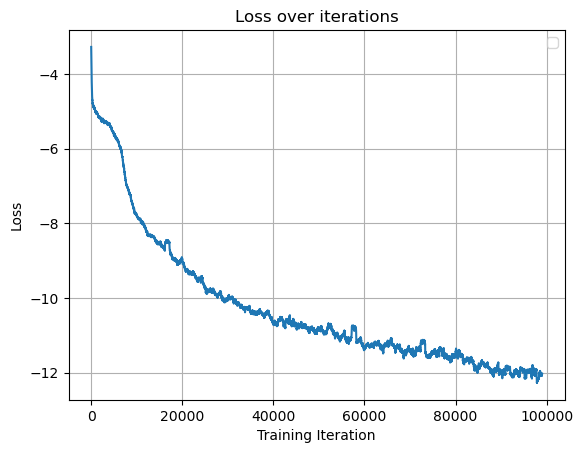

In [23]:
loss_data = np.array(loss_lst)

# Smoothing window size
window_size = 1000


smoothed_loss = np.convolve(loss_data, np.ones(window_size)/window_size, mode='valid')
lossX = [i for i in range(len(smoothed_loss))]

plt.plot(lossX, smoothed_loss)
plt.title("Loss over iterations")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()